In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [45]:
train_df = pd.read_csv("./fhs_train.csv", low_memory=False)
train_df = train_df.drop("Unnamed: 0", axis=1)
display(train_df.head())
print(train_df.isna().sum())

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,58,1.0,0,0.0,0.0,0,0,0,220.0,143.0,104.0,29.85,75,87.0,1
1,0,40,1.0,1,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85,77.0,0
2,0,52,1.0,0,0.0,0.0,0,0,0,275.0,112.0,71.0,25.68,80,NaN,0
3,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110,75.0,0
4,0,43,1.0,0,0.0,0.0,0,0,0,202.0,124.0,92.0,21.26,75,74.0,0


sex                  0
age                  0
education           85
currentSmoker        0
cigsPerDay          24
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             39
sysBP                0
diaBP                0
BMI                 15
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64


In [49]:
train_df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3180.000000,3180.000000,3095.000000,3180.000000,3156.000000,3143.000000,3180.000000,3180.000000,3180.000000,3141.000000,3180.000000,3180.000000,3165.000000,3180.000000,2895.000000,3180.000000
mean,0.433019,49.633962,1.957027,0.490881,8.970532,0.029590,0.006604,0.321069,0.026101,236.600764,132.784748,83.117767,25.888117,75.942138,81.833506,0.153145
std,0.495571,8.557596,1.011135,0.499995,12.013704,0.169479,0.081008,0.466961,0.159460,44.847411,22.433267,12.009212,4.130475,12.050504,23.625357,0.360184
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,50.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,117.000000,75.000000,23.100000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.000000,129.000000,82.000000,25.490000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.125000,90.000000,28.140000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,140.000000,394.000000,1.000000


In [46]:
print(train_df.shape)
print(train_df["TenYearCHD"].value_counts()) # 15.31% have chd
drop_train_df = train_df.dropna()
print(drop_train_df.shape) # 86.29% of train_df
print(drop_train_df["TenYearCHD"].value_counts()) # 15.45% have chd
na_train_df = train_df[train_df.isna().any(axis=1)]
print(na_train_df.shape) # 13.71% of train_df
print(na_train_df["TenYearCHD"].value_counts()) # 14.45% have chd

# for now choose to drop na values

(3180, 16)
TenYearCHD
0    2693
1     487
Name: count, dtype: int64
(2744, 16)
TenYearCHD
0    2320
1     424
Name: count, dtype: int64
(436, 16)
TenYearCHD
0    373
1     63
Name: count, dtype: int64


In [47]:
test_df = pd.read_csv("./fhs_test.csv", low_memory=False)
test_df = test_df.drop("Unnamed: 0", axis=1)
display(test_df.head())
print(test_df.isna().sum())

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,58,1.0,1,20.0,0.0,0,0,0,NaN,126.0,77.0,30.08,78.0,NaN,0
1,0,51,3.0,0,0.0,0.0,0,0,0,264.0,135.0,83.0,26.68,60.0,74.0,0
2,0,44,2.0,1,9.0,0.0,0,1,0,NaN,147.5,96.0,30.57,78.0,NaN,1
3,0,40,2.0,1,20.0,0.0,0,0,0,271.0,138.5,88.0,27.24,80.0,NaN,1
4,1,58,2.0,1,20.0,0.0,0,0,0,207.0,110.0,80.0,23.55,78.0,78.0,0


sex                  0
age                  0
education           20
currentSmoker        0
cigsPerDay           5
BPMeds              16
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             11
sysBP                0
diaBP                0
BMI                  4
heartRate            1
glucose            103
TenYearCHD           0
dtype: int64


In [48]:
test_df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,1060.000000,1060.000000,1040.000000,1060.000000,1055.000000,1044.000000,1060.000000,1060.000000,1060.000000,1049.000000,1060.000000,1060.000000,1056.000000,1059.000000,957.000000,1060.000000
mean,0.417925,49.418868,2.046154,0.503774,9.111848,0.029693,0.003774,0.279245,0.024528,236.995234,131.064151,82.237736,25.539100,75.689330,82.357367,0.148113
std,0.493450,8.620858,1.042774,0.500222,11.650215,0.169822,0.061342,0.448840,0.154755,43.835233,20.743991,11.589415,3.914418,11.953153,24.931659,0.355380
min,0.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.000000,92.500000,48.000000,15.960000,45.000000,44.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.000000,22.850000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,235.000000,127.000000,81.000000,25.140000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,265.000000,140.125000,88.000000,27.860000,82.000000,87.000000,0.000000
max,1.000000,69.000000,4.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,453.000000,215.000000,140.000000,45.790000,143.000000,394.000000,1.000000


In [50]:
print(test_df.shape)
print(test_df["TenYearCHD"].value_counts()) # 14.81% have chd
drop_test_df = test_df.dropna()
print(drop_test_df.shape) # 86.23% of train_df
print(drop_test_df["TenYearCHD"].value_counts()) # 14.55% have chd
na_test_df = test_df[test_df.isna().any(axis=1)]
print(na_test_df.shape) # 13.77% of train_df
print(na_test_df["TenYearCHD"].value_counts()) # 16.44% have chd

# for now choose to drop na values

(1060, 16)
TenYearCHD
0    903
1    157
Name: count, dtype: int64
(914, 16)
TenYearCHD
0    781
1    133
Name: count, dtype: int64
(146, 16)
TenYearCHD
0    122
1     24
Name: count, dtype: int64


In [117]:
xtrain = drop_train_df.drop("TenYearCHD", axis=1)
xtest = drop_test_df.drop("TenYearCHD", axis=1)
ytrain = drop_train_df["TenYearCHD"]
ytest = drop_test_df["TenYearCHD"]
print(ytrain.describe())
print(ytest.describe())

ntest = len(ytest)
tss = np.sum((ytest - ytrain.mean()) ** 2)

count    2744.000000
mean        0.154519
std         0.361511
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TenYearCHD, dtype: float64
count    914.000000
mean       0.145514
std        0.352812
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: TenYearCHD, dtype: float64


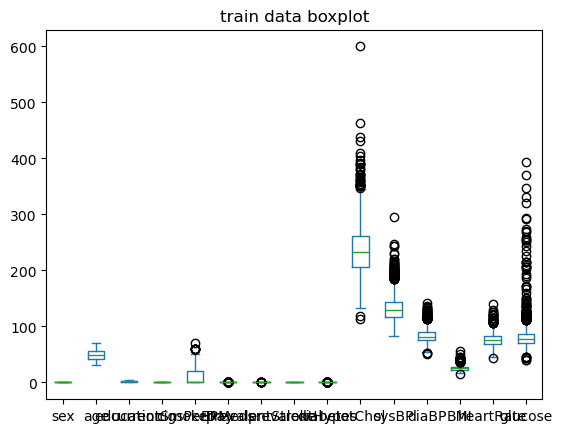

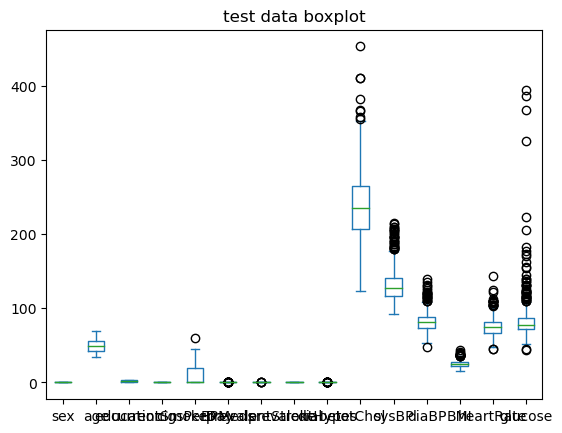

In [77]:
xtrain.plot.box()
plt.title("train data boxplot")
plt.show()
xtest.plot.box()
plt.title("test data boxplot")
plt.show()
# only sex, age, education, currentsmoker, and prevalenthyp do not have outliers

In [ ]:
# let's try and find which combination of columns gives the highest r-squared value

cols = [x for x in drop_train_df.columns if x != "TenYearCHD"]
fitdict = {}
for i in range(1, len(cols) + 1):
    for comb in combinations(cols, i):
        xtraincomb = drop_train_df[list(comb)]
        xtestcomb = drop_test_df[list(comb)]
        regcomb = LinearRegression().fit(xtraincomb, ytrain)
        fitdict[comb] = regcomb.score(xtestcomb, ytest)

maxkey = max(fitdict, key=fitdict.get)
print(f"best variables: {maxkey}, rsq: {fitdict[maxkey]}")


best variables: ('sex', 'age', 'education', 'currentSmoker', 'prevalentStroke', 'prevalentHyp', 'sysBP', 'glucose'), rsq: 0.10479024143270477


In [122]:
%%capture --no-display
%%script echo skipping

# run this block if you want to use only the variables that would maximize the r-squared value
xtrain = drop_train_df[["sex", "age", "education", "currentSmoker", "prevalentStroke", "prevalentHyp", "sysBP", "glucose"]]
xtest = drop_test_df[["sex", "age", "education", "currentSmoker", "prevalentStroke", "prevalentHyp", "sysBP", "glucose"]]

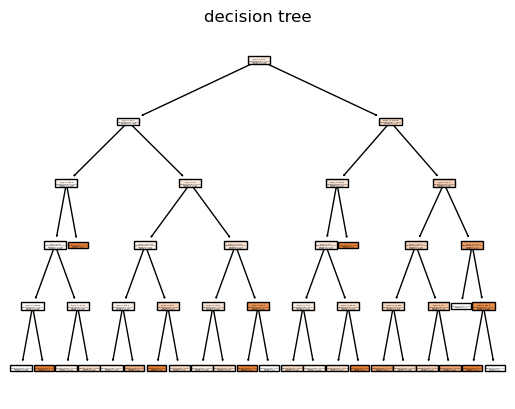

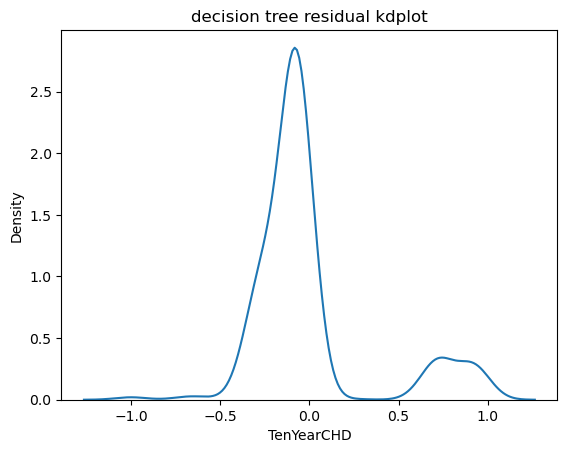

In [123]:
# tree approach:

cart = DecisionTreeRegressor(max_depth=5).fit(xtrain, ytrain)
plot_tree(cart, filled=True)
plt.title("decision tree")
plt.show()

yhat_tree = cart.predict(xtest)
residual = ytest - yhat_tree
sns.kdeplot(residual).set_title("decision tree residual kdplot")
plt.show()

sse_tree = np.sum((ytest - yhat_tree) ** 2)
mse_tree = sse_tree / ntest
rmse_tree = np.sqrt(sse_tree / ntest)
r2_tree = 1 - sse_tree / tss

minimum SSE: 105.26125; optimal k: 40


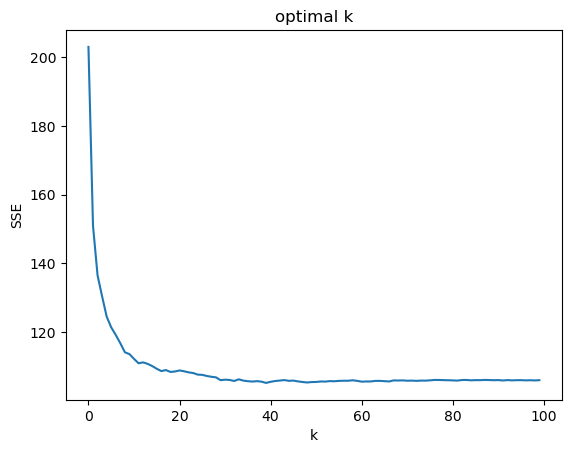

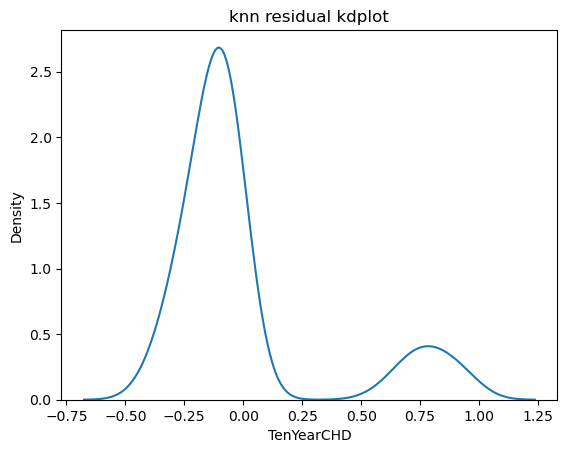

In [119]:
# kNN approach:
def maxmin(x):
    return (x - min(x)) / (max(x) - min(x))

xtrain_knn = xtrain.apply(maxmin)
xtest_knn = xtest.apply(maxmin)

karr = np.arange(1, 101)
sse = np.zeros(100)
ssemin = np.min(sse)
for k in range(100):
    model = KNeighborsRegressor(n_neighbors=k + 1).fit(xtrain_knn, ytrain)
    yhat = model.predict(xtest_knn)
    sse[k] = np.sum((ytest - yhat) ** 2)

ssemin = np.min(sse)
index = np.where(sse == ssemin)[0]
opt = karr[index]
print(f"minimum SSE: {ssemin}; optimal k:", end=" ")
print(*opt, sep=", ")
plt.plot(np.arange(100), sse)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("optimal k")
plt.show()

model = KNeighborsRegressor(n_neighbors=41).fit(xtrain_knn, ytrain)
yhat_knn = model.predict(xtest_knn)
residual = ytest - yhat_knn
sns.kdeplot(residual).set_title("knn residual kdplot")
plt.show()

sse_knn = np.sum((ytest - yhat_knn) ** 2)
mse_knn = sse_knn / ntest
rmse_knn = np.sqrt(sse_knn / ntest)
r2_knn = 1 - sse_knn / tss

R^2: 0.091860221638146


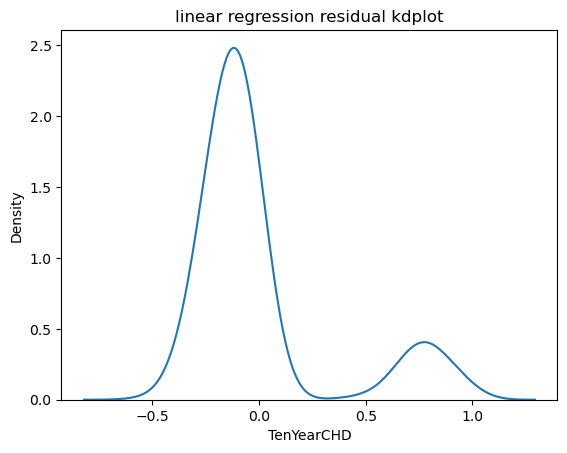

In [120]:
# linear regression approach:
reg = LinearRegression().fit(xtrain, ytrain)
print(f"R^2: {reg.score(xtest, ytest)}")
yhat_lr = reg.predict(xtest)
residual = ytest - yhat_lr
sns.kdeplot(residual).set_title("linear regression residual kdplot")
plt.show()

sse_lr = np.sum((ytest - yhat_lr) ** 2)
mse_lr = sse_lr / ntest
rmse_lr = np.sqrt(sse_lr / ntest)
r2_lr = 1 - sse_lr / tss


In [124]:
# comparison table:

cdf = pd.DataFrame({"SSE": [sse_knn, sse_lr, sse_tree], "MSE": [mse_knn, mse_lr, mse_tree], "RMSE": [rmse_knn, rmse_lr, rmse_tree], "R2": [r2_knn, r2_lr, r2_tree]})
cdf.index = ['kNN','LR','TREE']
cdf.head()

# wow these models are failures...maybe we would've gotten different results if we imputed values rather than dropped na's

,SSE,MSE,RMSE,R2
kNN,105.588340,0.115523,0.339887,0.071512
LR,103.207006,0.112918,0.336033,0.092452
TREE,107.728069,0.117864,0.343314,0.052696
